In [18]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



def calculate_dihedrals_batch(molecules, indices) -> np.array:
    """
    Calculate dihedral angles for a batch of molecules in a vectorized manner.
    
    Parameters:
    molecules (np.ndarray): Array of shape (n_molecules, n_atoms, 3) containing the coordinates of the atoms in each molecule.
    indices (list): List of 4 indices that define the dihedral angle for all molecules.
    
    Returns:
    np.ndarray: Array of dihedral angles for the batch of molecules.
    """
    n_molecules = molecules.shape[0]
    
    # Extract coordinates of the four atoms for all molecules
    p0 = molecules[:, indices[0], :]
    p1 = molecules[:, indices[1], :]
    p2 = molecules[:, indices[2], :]
    p3 = molecules[:, indices[3], :]
    
    # Compute the vectors between the points
    b0 = p1 - p0
    b1 = p2 - p1
    b2 = p3 - p2
    
    # Normalize b1
    b1 /= np.linalg.norm(b1, axis=1)[:, np.newaxis]
    
    # Compute normal vectors to the planes
    n0 = np.cross(b0, b1)
    n1 = np.cross(b1, b2)
    
    # Normalize the normal vectors
    n0 /= np.linalg.norm(n0, axis=1)[:, np.newaxis]
    n1 /= np.linalg.norm(n1, axis=1)[:, np.newaxis]
    
    # Compute the dihedral angles
    m1 = np.cross(n0, b1)
    x = np.einsum('ij,ij->i', n0, n1)
    y = np.einsum('ij,ij->i', m1, n1)
    angles = -np.degrees(np.arctan2(y, x))
    
    return angles
    

In [3]:
def plot_histogram(hist, xedges, yedges):
    plt.imshow(hist, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis')
    plt.colorbar()
    plt.xlabel('φ')
    plt.ylabel('Ψ')
    plt.title('Histogram of dihedral angles (log scale)')
    plt.show()

def plot_multiple_histograms(hists:list, xedges:list, yedges:list, titles:list = None):
    fig, axs = plt.subplots(1, len(hists), figsize=(15, 5))
    for i in range(len(hists)):
        hist = hists[i]
        xedge = xedges[i]
        yedge = yedges[i]
        axs[i].imshow(hist, origin='lower', extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]], cmap='viridis')
        axs[i].set_xlabel('φ')
        axs[i].set_ylabel('Ψ')
        if titles is not None:
            axs[i].set_title(titles[i])
    plt.tight_layout()
    plt.show()

def get_histogram_difference(hist1, hist2):

    return np.mean(np.abs(hist1 - hist2))

In [7]:
indizes1 = [4, 6, 8, 14]
indizes2 = [6, 8, 14, 16]    


traj_paper = np.load("/Users/lukas/Documents/KIT/Masterarbeit/git/gnn_uncertainty/datasets/files/ala_converged/test_cartesian.npy")
traj_henrik = np.load("/Users/lukas/Documents/KIT/Masterarbeit/git/gnn_uncertainty/datasets/files/ala_converged/prod_positions_20-09-2023_13-10-19.npy")

start_time = time.time()
psi_paper = calculate_dihedrals_batch(traj_paper, indizes1)
phi_paper = calculate_dihedrals_batch(traj_paper, indizes2)
psi_henrik = calculate_dihedrals_batch(traj_henrik, indizes1)
phi_henrik = calculate_dihedrals_batch(traj_henrik, indizes2)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for calculate_dihedrals_batch: {elapsed_time} seconds")


Elapsed time for calculate_dihedrals_batch: 120.13185596466064 seconds


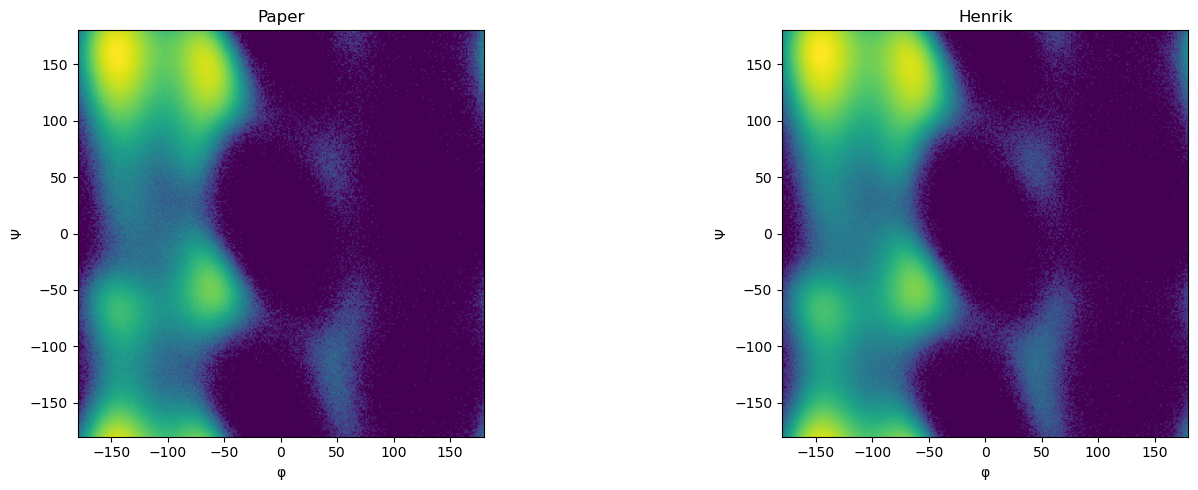

"\nplt.imshow(log_hist_henrik, origin='lower', extent=[xedges_henrik[0], xedges_henrik[-1], yedges_henrik[0], yedges_henrik[-1]], cmap='viridis')\nplt.colorbar()\nplt.xlabel('φ')\nplt.ylabel('Ψ')\nplt.title('Histogram of dihedral angles (log scale)')\nplt.show()\n"

In [8]:
# Calculate the logarithm of the occurrence count
hist_paper, xedges_paper, yedges_paper = np.histogram2d(phi_paper, psi_paper, bins=300)
hist_henrik, xedges_henrik, yedges_henrik = np.histogram2d(phi_henrik, psi_henrik, bins=300)
log_hist_paper = np.log(hist_paper+1)
log_hist_henrik = np.log(hist_henrik+1)


plot_multiple_histograms([log_hist_paper, log_hist_henrik], [xedges_paper, xedges_henrik], [yedges_paper, yedges_henrik], titles=["Paper", "Henrik"])
'''
plt.imshow(log_hist_henrik, origin='lower', extent=[xedges_henrik[0], xedges_henrik[-1], yedges_henrik[0], yedges_henrik[-1]], cmap='viridis')
plt.colorbar()
plt.xlabel('φ')
plt.ylabel('Ψ')
plt.title('Histogram of dihedral angles (log scale)')
plt.show()
'''

In [9]:
print(get_histogram_difference(log_hist_paper, log_hist_henrik))

0.3882490368091455


In [19]:
dihedral_angles = np.array([psi_henrik, phi_henrik]).T
scaler = StandardScaler()
dihedral_angles_scaled = scaler.fit_transform(dihedral_angles)

# Fit a Gaussian Mixture Model to the dihedral angles
gmm = GaussianMixture(n_components=4)  # Change n_components as needed
gmm.fit(dihedral_angles_scaled)

# plot the histogram log scaled 
hist, xedges, yedges = np.histogram2d(phi_henrik, psi_henrik, bins=50)
log_hist = np.log(hist+1)
plt.imshow(log_hist, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Blues')

# Overlay the GMM contours

x = np.linspace(xedges_henrik[0], xedges_henrik[-1], 100)
y = np.linspace(yedges_henrik[0], yedges_henrik[-1], 100)
X, Y = np.meshgrid(x, y)
XY = np.column_stack([X.ravel(), Y.ravel()])
XY_scaled = scaler.transform(XY)
Z = np.exp(gmm.score_samples(XY_scaled)).reshape(X.shape)
plt.contour(X, Y, Z, levels=10, linewidths=2, colors='r')
plt.colorbar()
plt.xlabel('Angle 1')
plt.ylabel('Angle 2')
plt.title('2D Histogram of Angle 1 and Angle 2 with GMM Contours')
plt.show()


KeyboardInterrupt: 

In [16]:
# Create a 2D histogram of the data
hist, xedges, yedges = np.histogram2d(phi_henrik, psi_henrik, bins=50)

# Generate sample points from the histogram
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
x_samples, y_samples = np.meshgrid(x_centers, y_centers)
x_samples = x_samples.ravel()
y_samples = y_samples.ravel()
weights = hist.ravel()

# Replicate sample points according to histogram weights
sample_points = np.repeat(np.column_stack([x_samples, y_samples]), weights.astype(int), axis=0)


# Fit a Gaussian Mixture Model to the sample points
gmm = GaussianMixture(n_components=5, n_init=10, covariance_type='full')
gmm.fit(sample_points)

# Create a 2D histogram of the sample points
sample_hist, sample_xedges, sample_yedges = np.histogram2d(sample_points[:, 0], sample_points[:, 1], bins=50)
log_sample_hist = np.log(sample_hist + 1)
plt.imshow(log_sample_hist, origin='lower', extent=[sample_xedges[0], sample_xedges[-1], sample_yedges[0], sample_yedges[-1]], cmap='Blues')

# Overlay the GMM contours on the sample histogram
x = np.linspace(sample_xedges[0], sample_xedges[-1], 100)
y = np.linspace(sample_yedges[0], sample_yedges[-1], 100)
X, Y = np.meshgrid(x, y)
XY = np.column_stack([X.ravel(), Y.ravel()])
Z = np.exp(gmm.score_samples(XY)).reshape(X.shape)
plt.contour(X, Y, Z, levels=10, linewidths=2, colors='r')
plt.colorbar()
plt.xlabel('Angle 1')
plt.ylabel('Angle 2')
plt.title('2D Histogram of Sample Points with GMM Contours')
plt.show()

KeyboardInterrupt: 

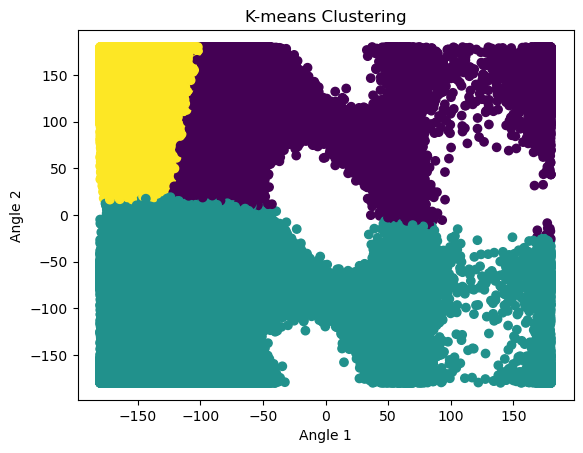

In [13]:
from sklearn.cluster import KMeans
n = 3
dihedral_angles = np.array([psi_henrik, phi_henrik]).T

# Perform K-means clustering
kmeans = KMeans(n_clusters=n)
kmeans.fit(dihedral_angles)

# Get the cluster labels
labels = kmeans.labels_

# Plot the clusters
plt.scatter(dihedral_angles[:, 0], dihedral_angles[:, 1], c=labels, cmap='viridis')
plt.xlabel('Angle 1')
plt.ylabel('Angle 2')
plt.title('K-means Clustering')
plt.show()

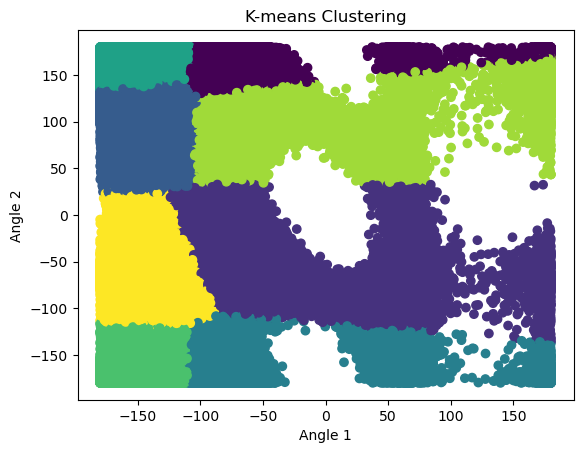

In [14]:
from sklearn.cluster import KMeans
n = 8
dihedral_angles = np.array([psi_henrik, phi_henrik]).T

# Perform K-means clustering
kmeans = KMeans(n_clusters=n)
kmeans.fit(dihedral_angles)

# Get the cluster labels
labels = kmeans.labels_

# Plot the clusters
plt.scatter(dihedral_angles[:, 0], dihedral_angles[:, 1], c=labels, cmap='viridis')
plt.xlabel('Angle 1')
plt.ylabel('Angle 2')
plt.title('K-means Clustering')
plt.show()